In [1]:
import pandas as pd
import numpy as np
from tqdm.notebook import tqdm 
import matplotlib.pyplot as plt

from sklearn.preprocessing import MinMaxScaler
import torch
import torch.nn as nn
import torch.optim as optim
from torch.utils.data import DataLoader, TensorDataset
from model.AnomalyTransformer import AnomalyTransformer # https://github.com/thuml/Anomaly-Transformer 모델 사용, forward 부분 수정

# 1. 데이터 로드
data = pd.read_csv('data/5528_12count/inter/5528_inter_imbalance_normal.csv')

# 2. null값 처리
data = data.dropna()

# # rms_xyz 값이 0.03 이상인 데이터만 사용
# data = data[data['rms_xyz'] >= 0.03]


# 데이터의 시간 정보를 사용하여 훈련 데이터와 테스트 데이터 나누기
# created_at 유닉스 시간대 컬럼을 기준으로 시계열 정렬
data['created_at'] = pd.to_datetime(data['created_at'], unit='s')
data = data.sort_values(by='created_at')

# 훈련 데이터와 테스트 데이터 분할
split_index = int(len(data) * 0.8035)
train_data = data[:split_index]
test_data = data[split_index:]
total_data = data

In [2]:
train_data.head

<bound method NDFrame.head of                                   asset_id          created_at  \
0     55285839-9b78-48d8-9f4e-573190ace016 2024-01-09 15:47:44   
1     55285839-9b78-48d8-9f4e-573190ace016 2024-01-09 17:47:53   
2     55285839-9b78-48d8-9f4e-573190ace016 2024-01-09 19:47:56   
3     55285839-9b78-48d8-9f4e-573190ace016 2024-01-09 21:48:05   
4     55285839-9b78-48d8-9f4e-573190ace016 2024-01-09 23:48:07   
...                                    ...                 ...   
1855  55285839-9b78-48d8-9f4e-573190ace016 2024-07-11 05:56:18   
1856  55285839-9b78-48d8-9f4e-573190ace016 2024-07-11 07:56:26   
1857  55285839-9b78-48d8-9f4e-573190ace016 2024-07-11 09:56:29   
1858  55285839-9b78-48d8-9f4e-573190ace016 2024-07-11 11:56:40   
1859  55285839-9b78-48d8-9f4e-573190ace016 2024-07-11 13:56:42   

     created_at_datetime     rms_x     rms_y     rms_z   rms_xyz  vel_rms_x  \
0        2024-01-10 0:47  0.015930  0.017679  0.019701  0.030894   0.201879   
1        2024-01-10

In [3]:
# 3. 필요한 특성 선택
train_features = train_data.drop(columns=['asset_id', 'created_at', 'created_at_datetime', 'looseness_health', 'time','misalignment_health', 'bearing_health', 'imbalance_health'])
test_features = test_data.drop(columns=['asset_id', 'created_at', 'created_at_datetime', 'looseness_health', 'time','misalignment_health', 'bearing_health', 'imbalance_health'])

# train_features = train_features.loc[:,['vel_crest_factor_x', 'rms_x', 'vel_kurtosis_y','vel_kurtosis_z', 'vel_peak_z','skewness_y','crest_factor_y','vel_skewness_x','vel_rms_xyz','peak_y','peak_x']]
# test_features = test_features.loc[:,['vel_crest_factor_x', 'rms_x', 'vel_kurtosis_y','vel_kurtosis_z', 'vel_peak_z','skewness_y','crest_factor_y','vel_skewness_x','vel_rms_xyz','peak_y','peak_x']]

In [4]:
train_features.columns.to_list()

['rms_x',
 'rms_y',
 'rms_z',
 'rms_xyz',
 'vel_rms_x',
 'vel_rms_y',
 'vel_rms_z',
 'vel_rms_xyz',
 'skewness_x',
 'skewness_y',
 'skewness_z',
 'vel_skewness_x',
 'vel_skewness_y',
 'vel_skewness_z',
 'kurtosis_x',
 'kurtosis_y',
 'kurtosis_z',
 'vel_kurtosis_x',
 'vel_kurtosis_y',
 'vel_kurtosis_z',
 'crest_factor_x',
 'crest_factor_y',
 'crest_factor_z',
 'vel_crest_factor_x',
 'vel_crest_factor_y',
 'vel_crest_factor_z',
 'peak_x',
 'peak_y',
 'peak_z',
 'vel_peak_x',
 'vel_peak_y',
 'vel_peak_z',
 'peak2peak_x',
 'peak2peak_y',
 'peak2peak_z',
 'vel_peak2peak_x',
 'vel_peak2peak_y',
 'vel_peak2peak_z']

In [6]:
train_features.shape , test_features.shape

((1860, 38), (456, 38))

In [7]:
# # 슬라이딩 윈도우 생성 시 12칸씩 슬라이딩 하려면 사용할 것
# train_feature = train_features[:1860]
# test_feature = test_features[:454]

In [18]:
test_features.head

<bound method NDFrame.head of          rms_x     rms_y     rms_z   rms_xyz  vel_rms_x  vel_rms_y  vel_rms_z  \
1860  0.248876  0.336719  0.184448  0.457537   1.820660   1.736150   1.234490   
1861  0.027954  0.026410  0.020692  0.043670   0.289131   0.232856   0.354582   
1862  0.030128  0.022910  0.019926  0.042774   0.306096   0.276771   0.285717   
1863  0.021468  0.019416  0.019482  0.034891   0.289937   0.267675   0.327995   
1864  0.028776  0.027220  0.020507  0.044604   0.288028   0.248949   0.397976   
...        ...       ...       ...       ...        ...        ...        ...   
2311  0.015997  0.015462  0.020731  0.030410   0.250990   0.291288   0.542528   
2312  0.014252  0.015412  0.020709  0.029488   0.237465   0.281824   0.415895   
2313  0.014229  0.015372  0.020380  0.029226   0.265960   0.204734   0.313585   
2314  0.022694  0.028622  0.022097  0.042690   0.288982   0.244747   0.327448   
2315  0.021358  0.038658  0.021757  0.049234   0.286048   0.239870   0.328683  

In [10]:
# 4. 정규화
scaler = MinMaxScaler()
train_features_scaled = scaler.fit_transform(train_features)
test_features_scaled = scaler.transform(test_features) # 테스트 데이터는 fit하면 안됨

# 5. 슬라이딩 윈도우 생성
window_size = 12 # 2시간 단위를 하루 단위의 status 지표에 맞추기 위해 12 사용
def create_windows(data, window_size):
    # return [data[i:i+window_size] for i in range(len(data) - window_size + 1)] # 1칸씩 슬라이딩 (123, 234, 345 ...)
    return [data[i:i + window_size] for i in range(0, len(data), window_size)] # window_size 만큼 구분지어 슬라이딩 (123, 456, 789 ...)

train_windows = create_windows(train_features_scaled, window_size)
test_windows = create_windows(test_features_scaled, window_size)

# 6. PyTorch 텐서로 변환
train_windows_tensor = torch.tensor(np.array(train_windows), dtype=torch.float32)
test_windows_tensor = torch.tensor(np.array(test_windows), dtype=torch.float32)

In [11]:
# for i, window in enumerate(train_windows):
#     print(f"Window {i} length: {len(window)}")
# for i, window in enumerate(test_windows):
#     print(f"Window {i} length: {len(window)}")

In [12]:
# 7. 데이터셋 및 데이터로더 생성
train_dataset = TensorDataset(train_windows_tensor)
test_dataset = TensorDataset(test_windows_tensor)

train_dataloader = DataLoader(train_dataset, batch_size=12, shuffle=True)
test_dataloader = DataLoader(test_dataset, batch_size=12, shuffle=False)

# 8. 모델 정의
model = AnomalyTransformer(win_size=window_size,  # 슬라이딩 윈도우 크기
                           enc_in=train_features.shape[1],  # 입력 특성 수
                           c_out=train_features.shape[1],  # 출력 특성 수
                          d_model=512)  
# 가능한 경우 cuda 사용
device = 'cuda' if torch.cuda.is_available() else 'cpu'
model = model.to(device)

# 9. 손실 함수 / 옵티마이저 설정
criterion = nn.MSELoss()
optimizer = optim.Adam(model.parameters(), lr=0.001)

# 10. 모델 학습
num_epochs = 100

best_loss = float('inf')  # 초기값으로 무한대 설정
best_model_state = None    # 최적 모델의 상태 저장

for epoch in tqdm(range(num_epochs)):
    model.train()
    epoch_loss = 0
    for batch in train_dataloader:
        inputs = batch[0].to(device)
        
        # 순전파
        outputs = model(inputs)
        
        # 손실 함수 적용
        loss = criterion(outputs, inputs)
        
        # 역전파
        optimizer.zero_grad()
        loss.backward()
        optimizer.step()
        
        epoch_loss += loss.item()

    avg_loss = epoch_loss / len(train_dataloader)
    print(f'Epoch {epoch + 1}/{num_epochs}, Loss: {avg_loss}')

    # 최적 모델 업데이트
    if avg_loss < best_loss:
        best_loss = avg_loss
        best_model_state = model.state_dict()  # 모델의 상태 저장

# 훈련 후 최적 모델 저장
if best_model_state is not None:
    torch.save(best_model_state, '0924_best_model_anomaly_transformer.pth')


  0%|          | 0/100 [00:00<?, ?it/s]

Epoch 1/100, Loss: 0.03554567637351843
Epoch 2/100, Loss: 0.022422412410378456
Epoch 3/100, Loss: 0.021861881017684937
Epoch 4/100, Loss: 0.021375227719545364
Epoch 5/100, Loss: 0.022160459166535966
Epoch 6/100, Loss: 0.021624995538821586
Epoch 7/100, Loss: 0.021058888747715034
Epoch 8/100, Loss: 0.023901762154239874
Epoch 9/100, Loss: 0.02208073451541937
Epoch 10/100, Loss: 0.021592844277620316
Epoch 11/100, Loss: 0.02152764439009703
Epoch 12/100, Loss: 0.02158268612737839
Epoch 13/100, Loss: 0.02162730894409693
Epoch 14/100, Loss: 0.02166786274084678
Epoch 15/100, Loss: 0.021353514291919194
Epoch 16/100, Loss: 0.021533494313748982
Epoch 17/100, Loss: 0.021566217192090474
Epoch 18/100, Loss: 0.021622836159972045
Epoch 19/100, Loss: 0.02131486039322156
Epoch 20/100, Loss: 0.02153239929332183
Epoch 21/100, Loss: 0.021357573138979766
Epoch 22/100, Loss: 0.02149331311766918
Epoch 23/100, Loss: 0.021460262055580433
Epoch 24/100, Loss: 0.02140469691501214
Epoch 25/100, Loss: 0.0214051359261

In [13]:
# 11. 모델 평가 (스코어링)
model.load_state_dict(torch.load('0924_best_model_anomaly_transformer.pth'))
model.eval()
anomaly_scores = []

with torch.no_grad():
    for batch in test_dataloader:
        inputs = batch[0].to(device)
        outputs = model(inputs)
        
        # 재구성 오차로 이상점수 계산
        batch_scores = torch.mean((outputs - inputs) ** 2, dim=(1, 2)).cpu().numpy()
        anomaly_scores.extend(batch_scores)

C:\Users\user\AppData\Local\Temp\ipykernel_6812\3690597930.py:2: FutureWarning: You are using `torch.load` with `weights_only=False` (the current default value), which uses the default pickle module implicitly. It is possible to construct malicious pickle data which will execute arbitrary code during unpickling (See https://github.com/pytorch/pytorch/blob/main/SECURITY.md#untrusted-models for more details). In a future release, the default value for `weights_only` will be flipped to `True`. This limits the functions that could be executed during unpickling. Arbitrary objects will no longer be allowed to be loaded via this mode unless they are explicitly allowlisted by the user via `torch.serialization.add_safe_globals`. We recommend you start setting `weights_only=True` for any use case where you don't have full control of the loaded file. Please open an issue on GitHub for any issues related to this experimental feature.
  model.load_state_dict(torch.load('0924_best_model_anomaly_tran

In [14]:
# 12. 임계값 계산
mean_score = np.mean(anomaly_scores)
std_score = np.std(anomaly_scores)

print(f'평균 스코어: {mean_score:.6f}')
print(f'표준편차: {std_score:.6f}')

# 임계값 설정 (평균 + 임의값 * 표준편차)

threshold = mean_score + 2.576 * std_score
print(f'임계값: {threshold:.6f}')

# 이상 점수 판별
anomalies = anomaly_scores > threshold
print(f'이상 점수 인덱스: {np.where(anomalies)[0]}')

평균 스코어: 0.019094
표준편차: 0.009478
임계값: 0.043510
이상 점수 인덱스: [12]


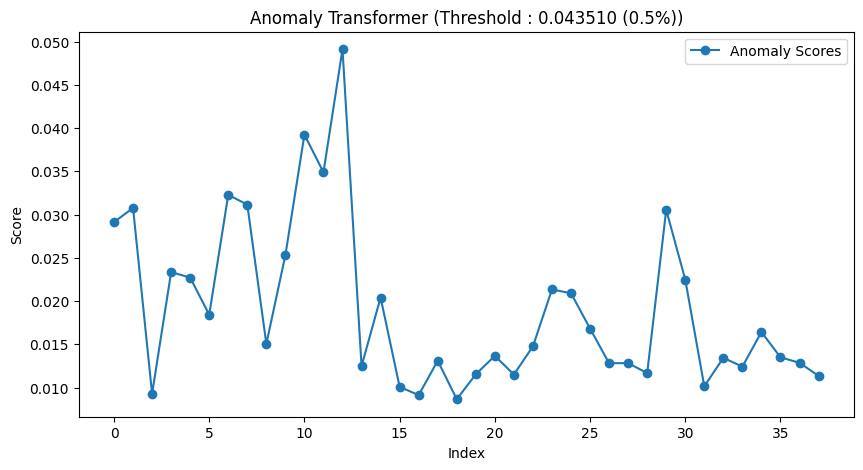

In [15]:
# 13. 인덱스 및 이상 점수 시각화
anomaly_indices = np.where(anomalies)[0]

plt.figure(figsize=(10, 5))
plt.plot(anomaly_scores, label='Anomaly Scores', marker='o')
# plt.axhline(y=threshold, color='r', linestyle='--', label='Threshold')
plt.xlabel('Index')
plt.ylabel('Score')
plt.title(f'Anomaly Transformer (Threshold : {format(threshold, '.6f')} (0.5%))')
plt.legend()
plt.show()

In [16]:
# 이상탐지된 인덱스 비교용
test_data_result=test_data.reset_index(drop=True)
# test_data_result=test_data.reset_index(drop=True)
indices = np.where(anomalies)[0].tolist()
test_data_result.loc[indices]

# test_data_result.loc[indices].to_csv("anomaly_transformer_result.csv")


,asset_id,created_at,created_at_datetime,rms_x,rms_y,rms_z,rms_xyz,vel_rms_x,vel_rms_y,vel_rms_z,...,peak2peak_y,peak2peak_z,vel_peak2peak_x,vel_peak2peak_y,vel_peak2peak_z,time,imbalance_health,misalignment_health,looseness_health,bearing_health
12,55285839-9b78-48d8-9f4e-573190ace016,2024-07-13 15:59:12,2024-07-14 0:59,0.234357,0.31787,0.182319,0.434977,3.60842,1.77499,1.72211,...,2.14453,1.38281,17.7402,10.3906,9.36983,2024-07-15 0:00,1,1,1,1
